## EE 521: Digital Signal Processors Lab
## Project Title: Combination of ARIMA and GARCH Model for Time Series Analysis and Its Application in Stock Price Prediction


- Submitted by:
 - Sqn Ldr Monark Singh
 - 214102322

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from arch import arch_model

In [7]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-poster')

In [8]:
stock = 'Dataset/TCS.csv'
df1 = pd.read_csv(stock)
df1.head()

Date Symbol Series  Prev Close    Open    High     Low    Last  \
0  2004-08-25    TCS     EQ      850.00  1198.7  1198.7  979.00  985.00   
1  2004-08-26    TCS     EQ      987.95   992.0   997.0  975.30  976.85   
2  2004-08-27    TCS     EQ      979.00   982.4   982.4  958.55  961.20   
3  2004-08-30    TCS     EQ      962.65   969.9   990.0  965.00  986.40   
4  2004-08-31    TCS     EQ      986.75   986.5   990.0  976.00  987.80   

    Close     VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  987.95  1008.32  17116372  1.725876e+15     NaN             5206360   
1  979.00   985.65   5055400  4.982865e+14     NaN             1294899   
2  962.65   969.94   3830750  3.715586e+14     NaN              976527   
3  986.75   982.65   3058151  3.005106e+14     NaN              701664   
4  988.10   982.18   2649332  2.602133e+14     NaN              695234   

   %Deliverble  
0       0.3042  
1       0.2561  
2       0.2549  
3       0.2294  
4       0.2624

In [9]:
df = pd.read_csv(stock,parse_dates=True,index_col='Date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).mean()['Close'])
df.columns=['Price']

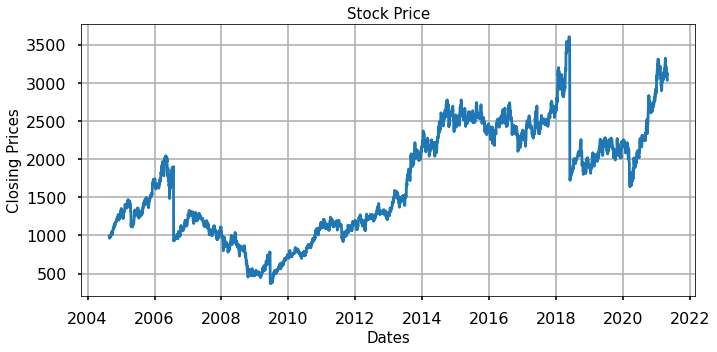

In [10]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(stock,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

# Plotting close price
plt.figure(figsize=(11,5))
plt.plot(data['Close'])
plt.title(f'Stock Price',size=15)
plt.xlabel('Dates',size=15)
plt.ylabel('Closing Prices',size=15)

plt.grid(True)
plt.show()

## We break down the ARIMA Model into 3 steps:

### 1. Check data for Stationarity.
### 2. Fitting an AR model: (AR)
### 3. Fitting an MA model on the residuals: (MA)


## Step 1: Check for Stationarity
### ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

- Null Hypothesis: The series has a unit root (value of a =1)

- Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

In [11]:
# Defining a function to check stationarity using ADF Test
# It takes the time series as input and returns ADF report
def adf_check(time_series):
    result = adfuller(time_series,autolag='AIC')
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("\n\033[1m p-value < 0.05 : Strong evidence against the null hypothesis.\033[0m")
        print("\n\033[1m Rejecting the null hypothesis.Data has no unit root and is Stationary.\033[0m")
    else:
        print("\n\033[1m p-value > 0.05 : Weak evidence against null hypothesis.\033[0m")
        print("\n\033[1m Time series has a unit root, indicating it is Non-Stationary.\033[0m\n")

In [12]:
df_price = pd.DataFrame(df.Price)
adf_check(df_price.Price.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.040197829674625
p-value : 0.7383222947545708
Number of Lags Used : 0
Number of Observations Used : 200

 p-value > 0.05 : Weak evidence against null hypothesis.

 Time series has a unit root, indicating it is Non-Stationary.



### Making the Data Stationary:

- Taking log and carrying out Differencing to make the data Stationary.
- From the results of the ADF test we have a strong evidence against the null hypothesis(p-value < 0.05). 
- Rejecting the null hypothesis. Data has no unit root and is Stationary.


In [13]:
df1['Price'] = df1['Close']
#df_testing = pd.DataFrame(np.log(df1.Price).diff(2))

df_log = pd.DataFrame(np.log(df1.Price))
df_stationary = df_log.diff(2)

adf_check(df_stationary.Price.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -13.958480692364118
p-value : 4.565392262154728e-26
Number of Lags Used : 29
Number of Observations Used : 4107

 p-value < 0.05 : Strong evidence against the null hypothesis.

 Rejecting the null hypothesis.Data has no unit root and is Stationary.


### Plotting the Stationary Signal

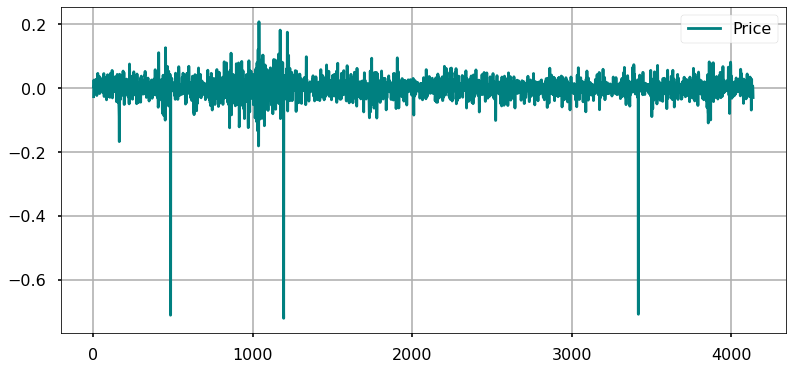

In [14]:
df_stationary.plot(color='teal', figsize=(13,6))
plt.grid(True)
plt.show()

### Step 2 : Fitting AR Model

## Auto-Regressive Model
- For a value at time t, we assume that it is linearly dependent on the previous p lagged values and there is an error term associated with it.

$$ y_t = c + \sum_{i=1}^{p}{\phi_i y_{t-i}} +{\epsilon_t} = c + {\phi_1 y_{t-1}}+{\phi_2 y_{t-2}}+...+{\phi_p y_{t-p}}+{\epsilon_t}
$$
- It is similar to linear regression, where X is the p-lagged values and y is the value at time t. 
- Here the order p can be chosen using ACF and PACF plots.

### PACF Plot:

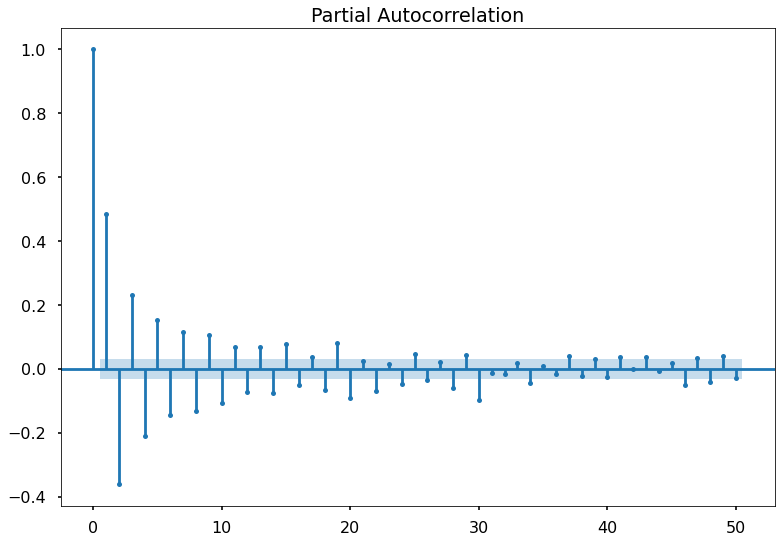

In [15]:
PACF = plot_pacf(df_stationary.dropna(),lags=50)

## AR(p) Model:

In [16]:
## Defining the Auto-Regression Model
def AR(p,df):
    df_temp = df

    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' %i ] = df_temp['Price'].shift(i)

    train_size = int(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train1 = df_train.dropna()     # Dropping the NA values

    # X_train has p Columns & Row dimension becomes whatever shape is needed to make it hold all the original data
    X_train = df_train1.iloc[:,1:].values.reshape(-1,p)
    
    # y_train has 1 Column & Row dimension becomes whatever shape is needed to make it hold all the original data
    y_train = df_train1.iloc[:,0].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    lr1 = LinearRegression()
    lr1.fit(X_train,y_train)

    theta1  = lr1.coef_.T
    intercept1 = lr1.intercept_
    
    # Prediction on Training Data
    df_train1['Predicted_values'] = X_train.dot(theta1) + intercept1

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    
    # Prediction on Teting Data
    df_test['Predicted_values'] = X_test.dot(theta1) + intercept1

    RMSE = np.sqrt(mean_squared_error(df_test['Price'], df_test['Predicted_values']))

    print(f"Value of p: {p}\t\tRMSE:{RMSE:.6f}")

    #return [df_train1,df_test,theta1,intercept1,RMSE]
    return [df_train1,df_test,RMSE]


### Computing the order of AR model based on Minimum Root Mean Square Error

Value of p: 1		RMSE:0.037128
Value of p: 2		RMSE:0.035348
Value of p: 3		RMSE:0.034090
Value of p: 4		RMSE:0.033312
Value of p: 5		RMSE:0.032848
Value of p: 6		RMSE:0.032602
Value of p: 7		RMSE:0.032447
Value of p: 8		RMSE:0.032046
Value of p: 9		RMSE:0.031764
Value of p: 10		RMSE:0.031462
Value of p: 11		RMSE:0.031357
Value of p: 12		RMSE:0.031292
Value of p: 13		RMSE:0.031265
Value of p: 14		RMSE:0.031290
Value of p: 15		RMSE:0.031265
Value of p: 16		RMSE:0.031206
Value of p: 17		RMSE:0.031195
Value of p: 18		RMSE:0.031108
Value of p: 19		RMSE:0.030993
Value of p: 20		RMSE:0.031013

 Best value of p is: 19 


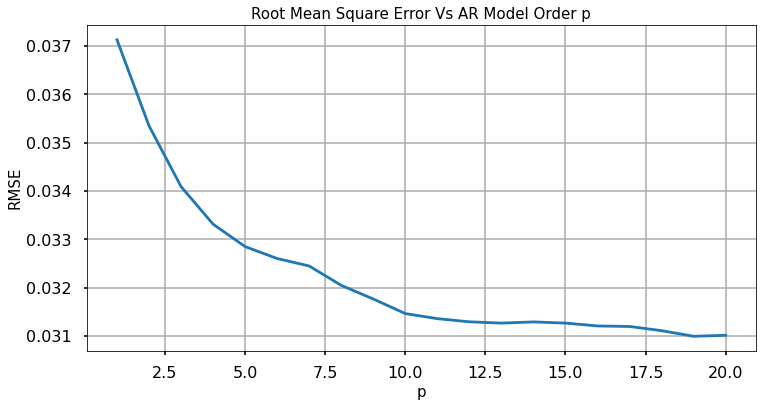

In [17]:
best_RMSE=1
best_p = 1

RMS_error = []
P = []
for i in range(1,21):
    [df_train,df_test,RMSE] = AR(i,pd.DataFrame(df_stationary.Price))
    
    RMS_error.append(RMSE)
    P.append(i)
    if(RMSE < best_RMSE):
        best_RMSE = RMSE
        best_p = i

print(f"\n\033[1m Best value of p is: {best_p} \033[0m")

plt.figure(figsize=(12,6))
plt.plot(P,RMS_error)
plt.title('Root Mean Square Error Vs AR Model Order p', size=15)
plt.xlabel('p', size=15)
plt.ylabel('RMSE',size=15)

plt.grid(True)
plt.show()

In [18]:
# Fitting the AR model with best value of p
[df_train,df_test,RMSE] = AR(best_p,pd.DataFrame(df_stationary.Price))


Value of p: 19		RMSE:0.030993


### Plotting the predictions on Stationary data

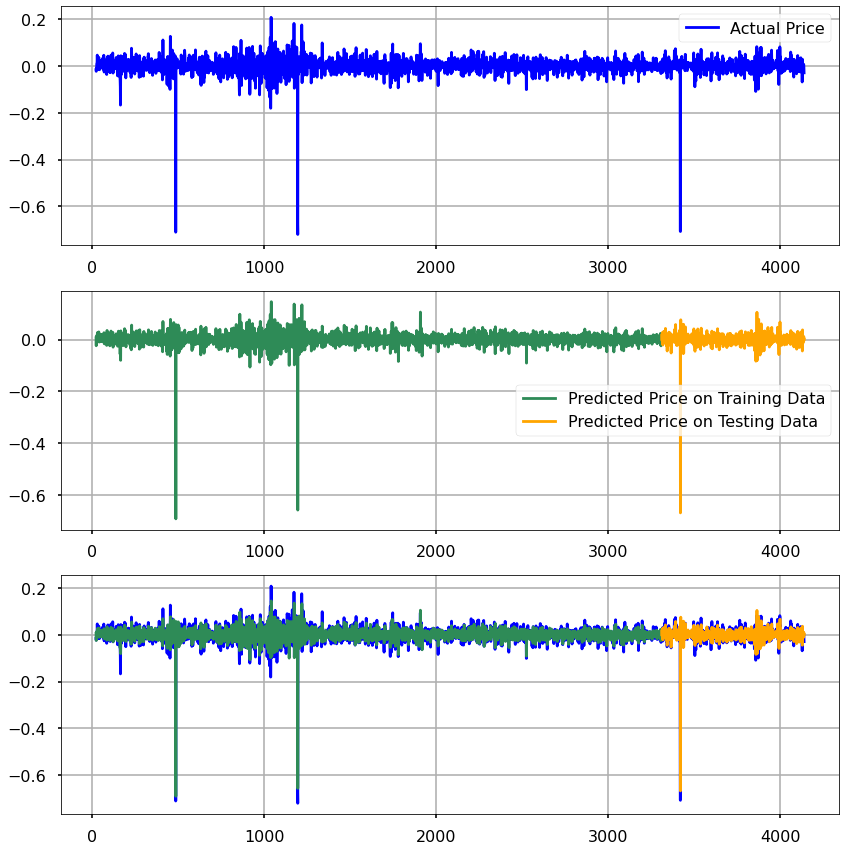

In [19]:
df_c = pd.concat([df_train,df_test])

plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.plot(df_c['Price'], label='Actual Price', color='blue')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(df_train['Predicted_values'], label='Predicted Price on Training Data', color='seagreen')
plt.plot(df_test['Predicted_values'], label='Predicted Price on Testing Data',color='orange')
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(df_c['Price'], color='blue')
plt.plot(df_train['Predicted_values'], color='seagreen')
plt.plot(df_test['Predicted_values'],color='orange')

plt.grid(True)
plt.tight_layout()
plt.show()

### Computing the Residues

In [20]:
res = pd.DataFrame()
res['Residuals'] = df_c.Price - df_c.Predicted_values

print("\nResidual Values of AR model:")
display(res)


Residual Values of AR model:


Residuals
21    -0.021513
22     0.001614
23    -0.009025
24    -0.006901
25     0.015602
...         ...
4134  -0.007672
4135   0.010697
4136  -0.004160
4137  -0.000838
4138  -0.030683

[4118 rows x 1 columns]

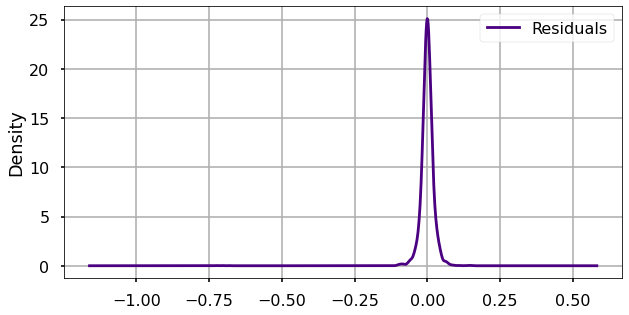

In [21]:
# PDF plot of the Residues

res.plot(kind='kde',color='indigo', figsize=(10,5))
plt.grid()
plt.show()

### Step 3 : Fitting MA model on Residues

## Moving Average Model

$$
Y_t = \mu + \sum_{i=1}^{q}{\theta_i \epsilon_{t-i}} +{\epsilon_t} = \mu + \epsilon_t + {\theta_1 \epsilon_{t-1}} +...+{\theta_q \epsilon_{t-q}}
$$

In [22]:
## Defining the Moving Average Model
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = int(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train1 = res_train.dropna()       # Dropping the NA values
    X_train = res_train1.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train1.iloc[:,0].values.reshape(-1,1)

    lr2 = LinearRegression()
    lr2.fit(X_train,y_train)

    theta2  = lr2.coef_.T
    intercept2 = lr2.intercept_

    # Computing Residuals on Training Data
    res_train1['Predicted_Error'] = X_train.dot(theta2) + intercept2

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)

    # Computing Residuals on Testing Data
    res_test['Predicted_Error'] = X_test.dot(theta2) + intercept2
    
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Error']))

    print(f"Value of q :{q}\t\tRMSE:{RMSE:.7f}")

    return [res_train1,res_test,RMSE]


### Computing the order of MA model based on Minimum Root Mean Square Error

Value of q :1		RMSE:0.0310594
Value of q :2		RMSE:0.0310601
Value of q :3		RMSE:0.0310263
Value of q :4		RMSE:0.0310348
Value of q :5		RMSE:0.0310288
Value of q :6		RMSE:0.0310264
Value of q :7		RMSE:0.0309995
Value of q :8		RMSE:0.0309646
Value of q :9		RMSE:0.0309770
Value of q :10		RMSE:0.0310057
Value of q :11		RMSE:0.0310681
Value of q :12		RMSE:0.0311114

 Best value of q is:8 


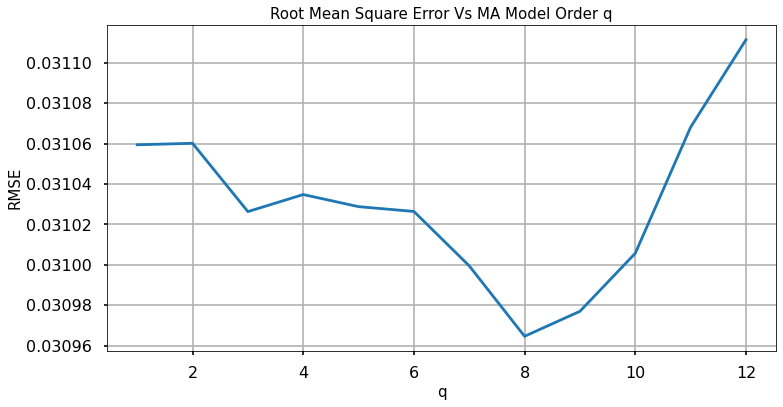

In [23]:
best_RMSE=1
best_q = 1

RMS_error = []
q = []
for i in range(1,13):
    [res_train,res_test,RMSE] = MA(i,pd.DataFrame(res.Residuals))
    RMS_error.append(RMSE)
    q.append(i)
    if(RMSE < best_RMSE):
        best_RMSE = RMSE
        best_q = i
  
print(f"\n\033[1m Best value of q is:{best_q} \033[0m")

plt.figure(figsize=(12,6))
plt.plot(q,RMS_error)
plt.title('Root Mean Square Error Vs MA Model Order q', size=15)
plt.xlabel('q', size=15)
plt.ylabel('RMSE',size=15)

plt.grid(True)
plt.show()

In [24]:
# Fitting the MA model with best value of q
[res_train,res_test,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))

Value of q :8		RMSE:0.0309646


### Updating the predicted prices by subtracting the predicted error from it.

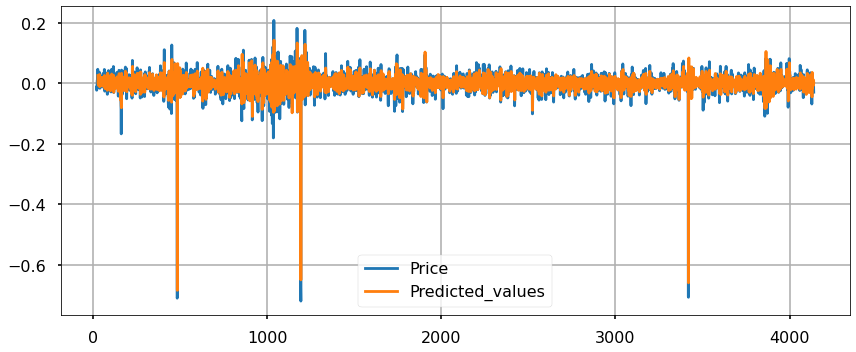

In [25]:
res_c = pd.concat([res_train,res_test])

# Subtracting the Predicted Errors from Predicted Prices
df_c.Predicted_values -= res_c.Predicted_Error
df_c[['Price','Predicted_values']].plot(figsize=(12, 5))

plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
df_c1 = pd.DataFrame()
df_c1['Price'] = df_c['Price']
df_c1['Predicted_values'] = df_c['Predicted_values']

df_c1 = df_c1.dropna()

display(df_c1)

Price  Predicted_values
29    0.031012          0.026031
30    0.004726          0.003413
31    0.015061         -0.002297
32    0.015094          0.011052
33    0.003231          0.003588
...        ...               ...
4134 -0.005788          0.003014
4135  0.007210         -0.005159
4136  0.007486          0.012131
4137 -0.005362         -0.003959
4138 -0.028721          0.001151

[4110 rows x 2 columns]

### Step 4 : Getting Back The Original Data
- Applying the inverse of the transformation which was applied to make the data stationary to get back the original data. 
- Taking cumulative sum of the prices followed by exponential operation.

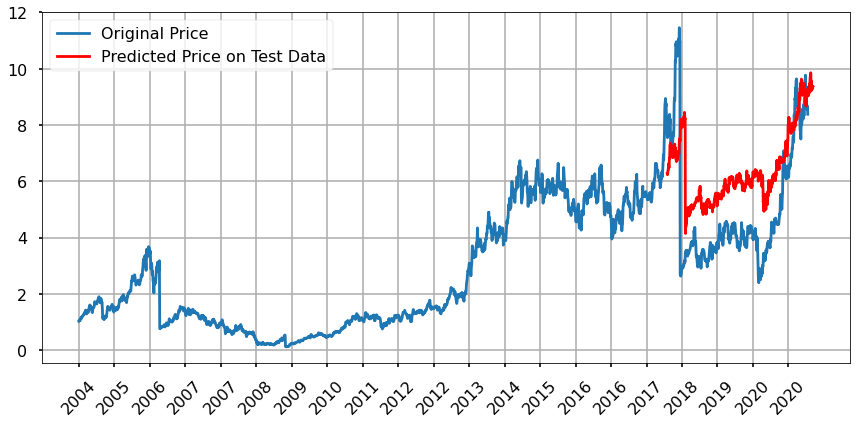

In [27]:
df_orig1 = np.exp(df_c1['Price'].cumsum()) 
df_orig2 = np.exp(df_c1['Predicted_values'].cumsum()) 

N = len(df_orig1)
N1 = int(0.8*N)

df_orig_true = df_orig1[N1:]
df_orig_pred = df_orig2[N1:]

n = len(df1)-len(df_c1)
time = pd.DatetimeIndex(df1.Date[n:]).year
t = np.asarray(time)
x = np.arange(0,len(t))

plt.figure(figsize=(12,6))
plt.xticks(x, t[::], rotation=45)
plt.locator_params(axis='x', nbins=len(x)/200)

plt.plot(x,df_orig1,label='Original Price')
plt.plot(df_orig_pred,color='red', label='Predicted Price on Test Data')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

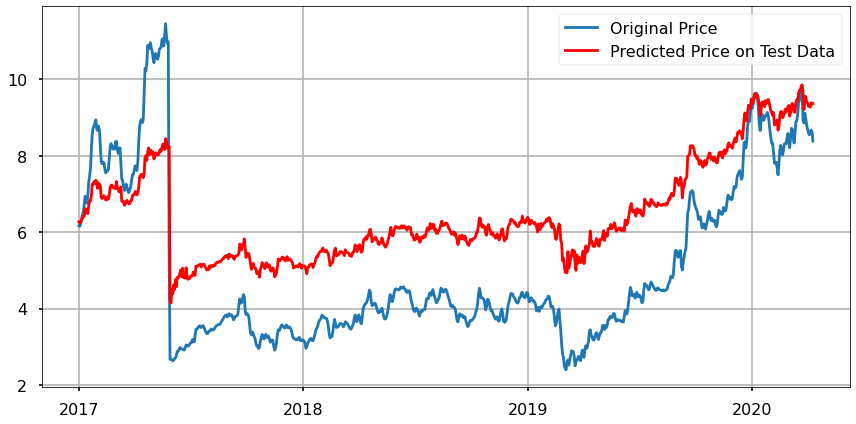

In [28]:
N = len(df_c1)
n = len(df1)-len(df_c1)
time = pd.DatetimeIndex(df1.Date[N1:N]).year
t = np.asarray(time)
x = np.arange(0,len(t))

plt.figure(figsize=(12,6))
plt.xticks(x, t[::], rotation=0)
plt.locator_params(axis='x', nbins=len(x)/250)

plt.plot(x,df_orig_true,label='Original Price')
plt.plot(x,df_orig_pred,color='red', label='Predicted Price on Test Data')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Computing the Mean Squared Error

In [29]:
# Calculation of Mean Squared Error (MSE)
MSE = mean_squared_error(df_orig_true,df_orig_pred)

print(f'\n\033[1mThe Mean Squared Error between the actual price and predicted price is: {MSE:.2f}%\033[0m')


The Mean Squared Error between the actual price and predicted price is: 3.28%


### Computing the Daily Returns of the Stock Price

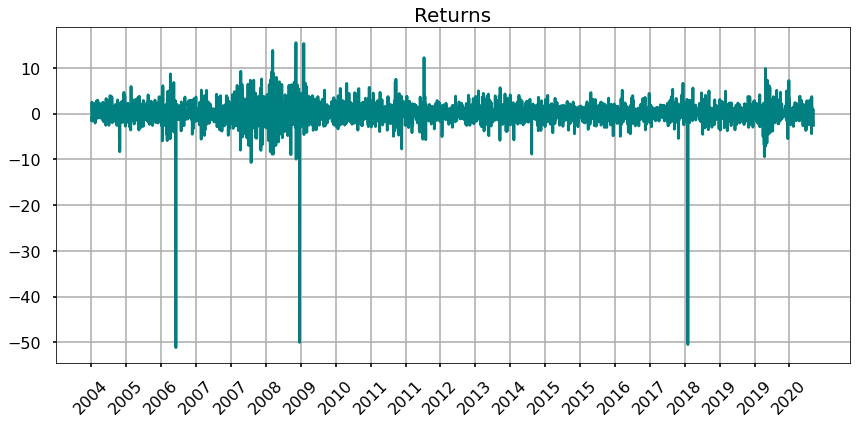

In [30]:
df = pd.read_csv(stock)
returns = 100* df1.Close.pct_change()
ret = np.array(returns)

df2 = pd.read_csv(stock,parse_dates=True,index_col='Date')
df1['Returns'] = ret


time = pd.DatetimeIndex(df1.Date[:]).year
t = np.asarray(time)
x = np.arange(0,len(t))

plt.figure(figsize=(12,6))
plt.xticks(x, t[::], rotation=45)
plt.locator_params(axis='x', nbins=len(x)/200)

plt.plot(x,df1['Returns'], color='teal')
plt.title('Returns',size=20)
plt.grid(True)
plt.tight_layout()
plt.show()

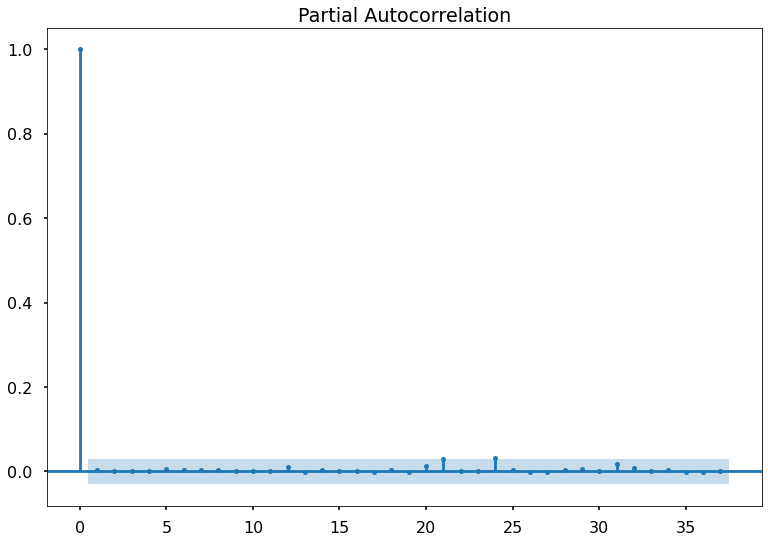

In [31]:
returns = returns.dropna()
plot_pacf(returns**2)
plt.show()

## GARCH(p,q) Model:

$$
\sigma^{2}_t = \omega + \sum_{i=1}^{q}{\alpha_i \epsilon^{2}_{t-i}}+ \sum_{i=1}^{p}{\beta_i \sigma^{2}_{t-i}} 
$$

### Taking GARCH(1,1) Model

In [32]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19421.279834851426
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17972.039000030807
Iteration:      3,   Func. Count:     25,   Neg. LLF: 13599.987984906598
Iteration:      4,   Func. Count:     32,   Neg. LLF: 9019.572176302278
Iteration:      5,   Func. Count:     37,   Neg. LLF: 9021.919484140388
Iteration:      6,   Func. Count:     43,   Neg. LLF: 9019.388880591201
Iteration:      7,   Func. Count:     48,   Neg. LLF: 9019.387122601433
Iteration:      8,   Func. Count:     53,   Neg. LLF: 9019.387112671808
Iteration:      9,   Func. Count:     57,   Neg. LLF: 9019.387095338312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9019.387112671808
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


In [33]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9019.39
Distribution:                  Normal   AIC:                           18046.8
Method:            Maximum Likelihood   BIC:                           18072.1
                                        No. Observations:                 4138
Date:                Fri, Apr 29 2022   Df Residuals:                     4137
Time:                        19:44:02   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0383  5.251e-02      0.730      0.465 [-6.458e-02,  0.141]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0704      0.102      0.690      0.490     [ -0.130,  0.271]
alpha[1]       0.0660  1.062e-02      6.210  5.293e-10 [4.514e-02,8.678e-02]
beta[1]        0.9340  2.959e-02     31.569 9.851e-219     [  0.876,  0.992]
============================================================================

Covariance estimator: robust
"""

In [34]:
volatility_predictions = []
test_size = len(df_orig_pred)    # Size of testing data

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    
    # Taking variance of the predicted result to compute Volatility
    volatility_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

/Users/monarksingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


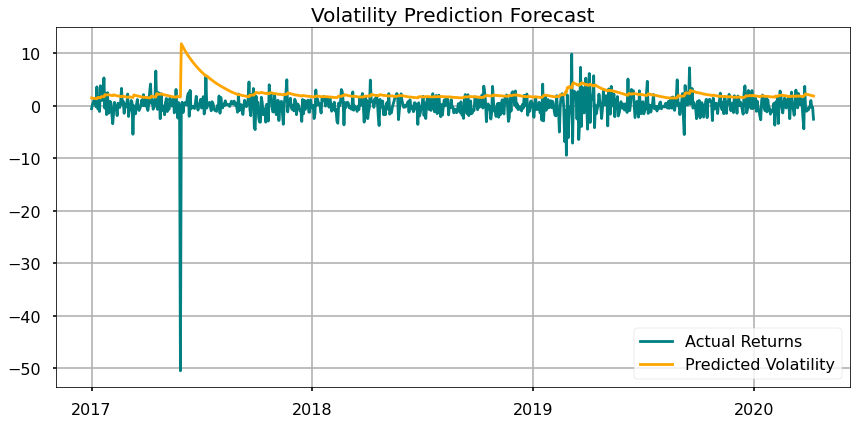

In [35]:
volatility_predictions = pd.Series(volatility_predictions, index=returns.index[-test_size:])

time = pd.DatetimeIndex(df1.Date[N1:N]).year
t = np.asarray(time)
x = np.arange(0,len(t))

plt.figure(figsize=(12,6))
plt.xticks(x, t[::], rotation=0)
plt.locator_params(axis='x', nbins=len(x)/250)

plt.plot(x,returns[-test_size:], color='teal')
plt.plot(x,volatility_predictions, color='orange')

plt.title('Volatility Prediction Forecast', fontsize=20)
plt.legend(['Actual Returns', 'Predicted Volatility'], fontsize=16)

plt.grid(True)
plt.tight_layout()
plt.show()

## Decision Rule:
### The decision to make a buy or sell decision can be made by analysing the prices as predicted by ARIMA model and the volatility in the prices as predicted by GARCH model.
### It is seen that the prediction error is more when market is more volatile so during that time buying/selling of that particular stock should be avoided.
### It is to be noted here that this prediction only takes into account the past prices of the stock and does not consider various other external factors like changing geopolitical scenarios, economic crisis, pandemic, wars etc. which may cause the market to crash which will not be predicted by this model.